In [15]:
from astropy.io.fits import getdata
import glob
from matplotlib import pyplot as plt
import os
from astropy.table import Table
import corner
import pandas as pd
from astropy import units as u
from scipy import optimize

import numpy as np

fpma_gain_shift = {
                'det0':0.9933,
                'det1':0.9919,
                'det2':0.9993,
                'det3':0.9973
                }

fpmb_gain_shift = {
                'det0':0.9955,
                'det1':0.9929,
                'det2':0.9928,
                'det3':0.9960
                }



219250800.0 s


In [95]:
def piecewise_linear(t, en0, change1, shift1, change2, shift2):

    dt1 = change1    
    dt2 = np.max(t) - change2
   
    f1 = lambda t: en0 * ( 1 - (1.0 - shift1) * t / dt1)
    f2 = lambda t: en0 * shift1
    f3 = lambda t: (en0 * shift1) * (1.0 - (1.0 - shift2) * (t - change2) / dt2)

    fx = np.select( [t < change1, (t>=change1) & (t<change2), t>=change2], [f1(t), f2(t), f3(t)])

    return fx
    



In [96]:
def load_chain(chain_file, test_entry='LineE__1'):
    chain = Table.read(chain_file)
    df = chain.to_pandas()

    for entry in df:
        if test_entry != entry:
            continue


        q = corner.quantile(df[entry], [0.16, 0.5, 0.84])
        cent = q[1]
        err = 0.5* ((q[1] - q[0]) + (q[2] - q[1]))
    return cent, err




In [113]:
def loop_epochs(det='0', mod = 'A', fit_change1=False,free_drift=False, fit_line=False):
    
    gain_met = 159663600. # from CALDB file
    launch_met=77241600. # 2012-06-13T00:00:00

    gain_date = ((gain_met - launch_met)*u.s).to(u.yr).value
    epochs_per_yr = 2.

    change1 = gain_date*epochs_per_yr


    
    
    chain_files = sorted(glob.glob('epoch*det{}*FPM{}*chain.fits'.format(det, mod)))
    epochs = []
    line_cent = []
    line_err = []
    # Get 105.3 keV fits
    for file in chain_files:
        epoch_str = (file.split('_'))[0]
        epoch = float((epoch_str[5:]))

        epochs.append(epoch)
        cent, err = load_chain(file)
        line_cent.append(float(cent))
        line_err.append(float(err))

        
    epochs = np.array(epochs)
    td = np.linspace(0, np.max(epochs), 40)
    
    if mod == 'A':
        gain_drift = fpma_gain_shift['det{}'.format(det)]
    else:
        gain_drift = fpmb_gain_shift['det{}'.format(det)]

        
    p0 = [105.3, change1, gain_drift, 7.0, 0.997]
    
    if fit_line is True:
        line_tol = 1.
    else:
        line_tol = 1e-3
    
    if free_drift:
        drift_tol = 1e-2
    else:
        drift_tol = 1e-4
    
    if fit_change1:
        change1_tol = 2.
    else:
        change1_tol = 1e-4
    
    
    bounds = ([105.3-line_tol, change1-change1_tol, gain_drift-drift_tol, 5.0, 0.9 ],
              [105.3+line_tol, change1+change1_tol, gain_drift + drift_tol, 10.0, 1.1])
        
    
    plt.errorbar(epochs, line_cent, line_err, fmt='.')
    
    # Do piecewise linear fit
    p , pcov = optimize.curve_fit(piecewise_linear, epochs, line_cent, sigma=line_err, p0 = p0,
                              bounds = bounds)

    print('First guess: ', p0)
    print('Fit: ', p)
    perr = np.sqrt(np.diag(pcov))
    print('Errors: ', perr)


    plt.plot(td, piecewise_linear(td, *p), '.')

    plt.show()

    
    est_lines = piecewise_linear(epochs, *p)

    plt.errorbar(epochs, line_cent / est_lines, line_err / est_lines, fmt = '.')
    plt.show()

#     # Load 144 keV line:
    

    line_cent = []
    line_err = []
    for file in chain_files:
        cent, err = load_chain(file, test_entry='LineE__4')
        line_cent.append(float(cent))
        line_err.append(float(err))



    plt.errorbar(epochs, line_cent, line_err, fmt='.')
    p144_0 = p
    p144_0[0] = 144.5
    drift_tol = 1e-4
    line_tol = 0.5
    bounds = ([144.5-0.5, p[1]-1e-5, p[2]-1e-4, p[3]-1e-4, p[4]-1e-4 ],
              [144.5+0.5, p[1], p[2], p[3], p[4]])
    p144 , e = optimize.curve_fit(piecewise_linear, epochs, line_cent, sigma=line_err, p0 = p144_0,
                              bounds = bounds)

    print('Fit to 144.5 keV line')
    print(p144)

    est_lines = piecewise_linear(epochs, *p144)
    plt.plot(epochs, est_lines, '.')
    plt.show()


    plt.errorbar(epochs, line_cent / est_lines, line_err / est_lines, fmt = '.')

    plt.show()


First guess:  [105.3, 5.223591147615788, 0.996, 7.0, 0.997]
Fit:  [105.3623714    5.93866056   0.99606238   7.48775424   0.99732942]
Errors:  [4.06124648e-02 1.11393428e+00 6.08367773e-04 1.64943566e+00
 5.85196706e-04]


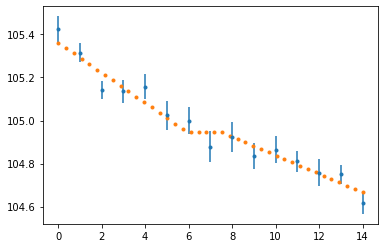

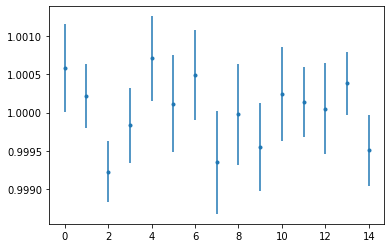

Fit to 144.5 keV line
[144.59624026   5.93865056   0.99606238   7.48775424   0.99732942]


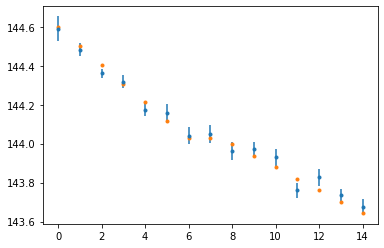

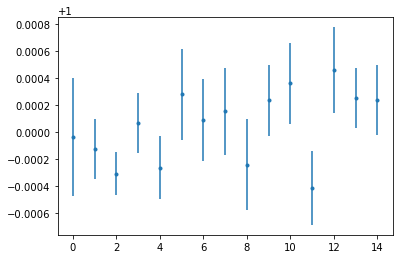

In [117]:
loop_epochs(mod='B',det = '3', free_drift = True, fit_line=True, fit_change1=True)